In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt

2025-09-26 07:05:32.859217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758870333.061767      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758870333.121229      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() #load
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1758870347.068463      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758870347.069248      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

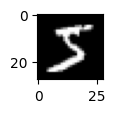

In [3]:
#see the images first 10
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")
plt.show()

In [4]:
def conv_model(input_shape=(28, 28, 1)):
  model = Sequential([
      layers.Conv2D(32, 3, (1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape),
      layers.Conv2D(32, 3, (1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, 3, (1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
      layers.Conv2D(64, 3, (1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
      layers.MaxPooling2D((2,2)),

      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])
  plot_model(model, to_file='conv_model.png', show_shapes=True, show_layer_names=True)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [5]:
#let's create the ResNet model
def resnet_block(x, filters, stride=1, weight_decay=0.0):
  shortcut = x
  x = layers.Conv2D(filters, 3, strides = stride, padding = 'same', use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filters, 3, strides = 1, padding = 'same', use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(x)
  x = layers.BatchNormalization()(x)
  if stride != 1 or shortcut.shape[-1] != filters:
    shortcut = layers.Conv2D(filters, 1, strides = stride, use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
  x = layers.Activation('relu')(x)
  return x

def resnet(input_shape=(28, 28, 1), num_classes=10, weight_decay=0.0):
  inputs = layers.Input(shape=input_shape)
  x = layers.Conv2D(32, 3, strides = 1, padding = 'same', use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = resnet_block(x, 32, 1, weight_decay)
  x = resnet_block(x, 32, 1, weight_decay)

  x = resnet_block(x, 64, 2, weight_decay)
  x = resnet_block(x, 64, 1, weight_decay)

  x = resnet_block(x, 128, 2, weight_decay)
  x = resnet_block(x, 128, 1, weight_decay)

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x) # Added this line

  model = models.Model(inputs, outputs) # Changed x to outputs
  plot_model(model, to_file='resnet_model.png', show_shapes=True, show_layer_names=True)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [6]:
history_conv = conv_model().fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1758870370.418889      98 service.cc:148] XLA service 0x7ca360006810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758870370.419521      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758870370.419542      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758870370.765104      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  48/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4061 - loss: 2.7724

I0000 00:00:1758870373.483127      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9049 - loss: 0.5731 - val_accuracy: 0.9792 - val_loss: 0.1270
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9768 - loss: 0.1362 - val_accuracy: 0.9778 - val_loss: 0.1163
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9812 - loss: 0.1111 - val_accuracy: 0.9801 - val_loss: 0.1152
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9857 - loss: 0.0921 - val_accuracy: 0.9809 - val_loss: 0.1033
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9870 - loss: 0.0843 - val_accuracy: 0.9862 - val_loss: 0.0812
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9885 - loss: 0.0755 - val_accuracy: 0.9868 - val_loss: 0.0750
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9895 - loss: 0.0686 - val_accuracy: 0.9860 - val_loss: 0.0756
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9914 - loss: 0.0622 - val_accura

In [7]:
history_resnet = resnet().fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.9258 - loss: 0.2522 - val_accuracy: 0.9823 - val_loss: 0.0566
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9862 - loss: 0.0461 - val_accuracy: 0.9792 - val_loss: 0.0648
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9898 - loss: 0.0334 - val_accuracy: 0.9784 - val_loss: 0.0656
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9904 - loss: 0.0314 - val_accuracy: 0.9939 - val_loss: 0.0185
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9920 - loss: 0.0252 - val_accuracy: 0.9861 - val_loss: 0.0402
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9938 - loss: 0.0197 - val_accuracy: 0.9908 - val_loss: 0.0296
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9946 - loss: 0.0176 - val_accuracy: 0.9926 - val_loss: 0.0231
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9949 -

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

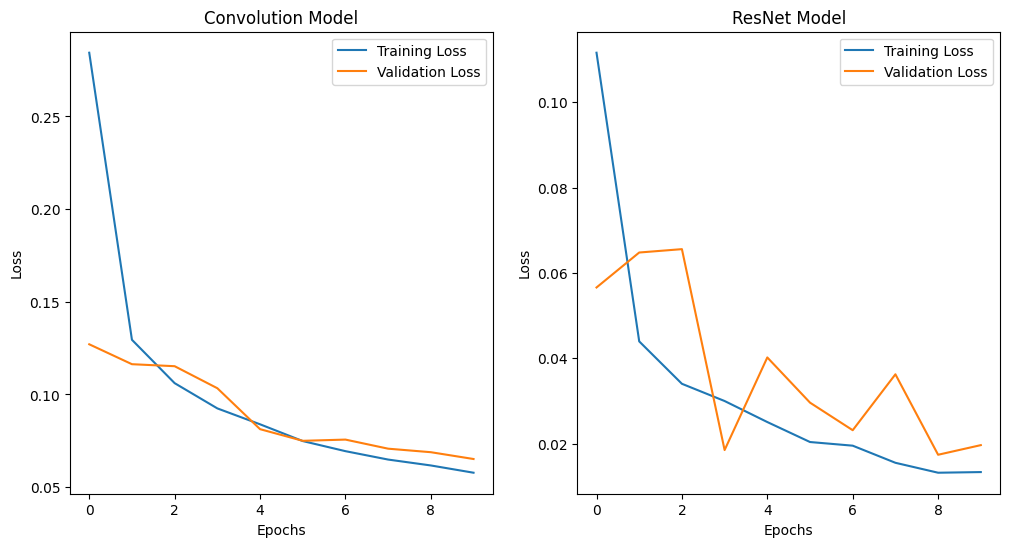

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.lineplot(history_conv.history['loss'], label='Training Loss')
sns.lineplot(history_conv.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.title("Convolution Model")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
sns.lineplot(history_resnet.history['loss'], label='Training Loss')
sns.lineplot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ResNet Model")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

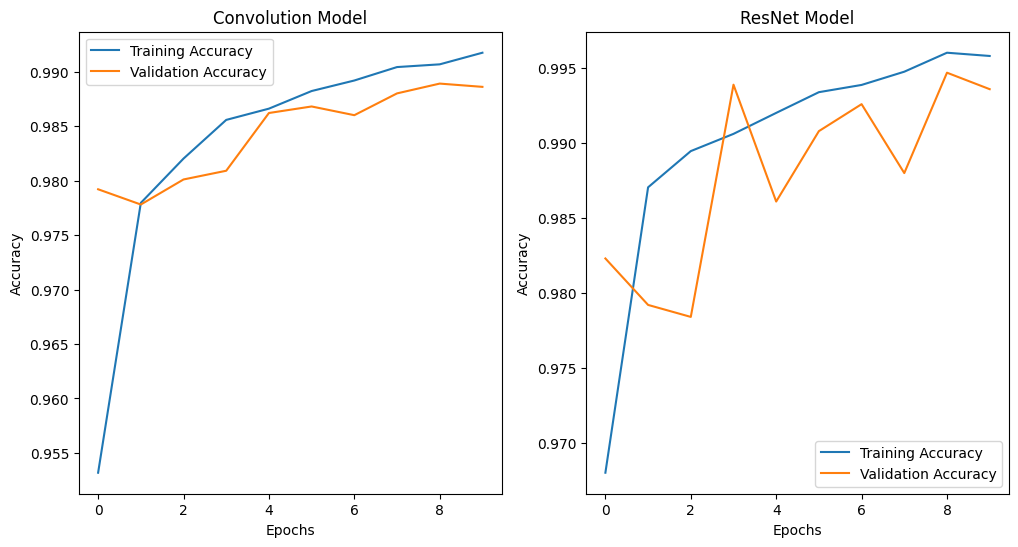

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.lineplot(history_conv.history['accuracy'], label='Training Accuracy')
sns.lineplot(history_conv.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.title("Convolution Model")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
sns.lineplot(history_resnet.history['accuracy'], label='Training Accuracy')
sns.lineplot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ResNet Model")
plt.legend()
plt.show()

In [30]:
model_conv = conv_model()
model_resnet= resnet()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(10000).batch(32)

In [28]:
x_batch, y_batch = next(iter(train_dataset))

with tf.GradientTape() as tape:
    logits= model_conv(x_batch, training=True)
    loss= loss_fn(y_batch, logits)

grads = tape.gradient(loss, model_conv.trainable_weights)    

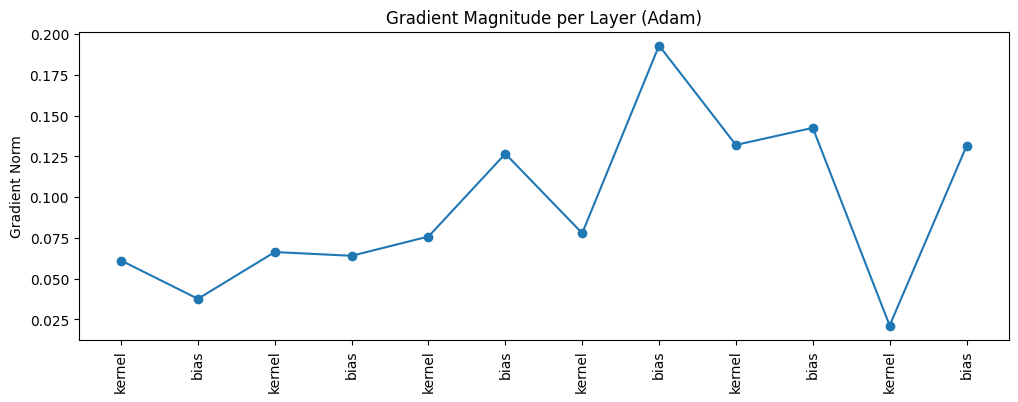

In [29]:
grad_norms = []
layer_names = []

for var, grad in zip(model_conv.trainable_weights, grads):
    if grad is not None:
        grad_norms.append(tf.norm(grad).numpy())
        layer_names.append(var.name)

plt.figure(figsize=(12,4))
plt.plot(grad_norms, marker='o')
plt.xticks(range(len(layer_names)), layer_names, rotation=90)
plt.ylabel("Gradient Norm")
plt.title("Gradient Magnitude per Layer in Covolution Networks")
plt.show()

In [33]:
with tf.GradientTape() as tape:
    logits= model_resnet(x_batch, training=True)
    loss= loss_fn(y_batch, logits)

grads_rn = tape.gradient(loss, model_resnet.trainable_weights) 

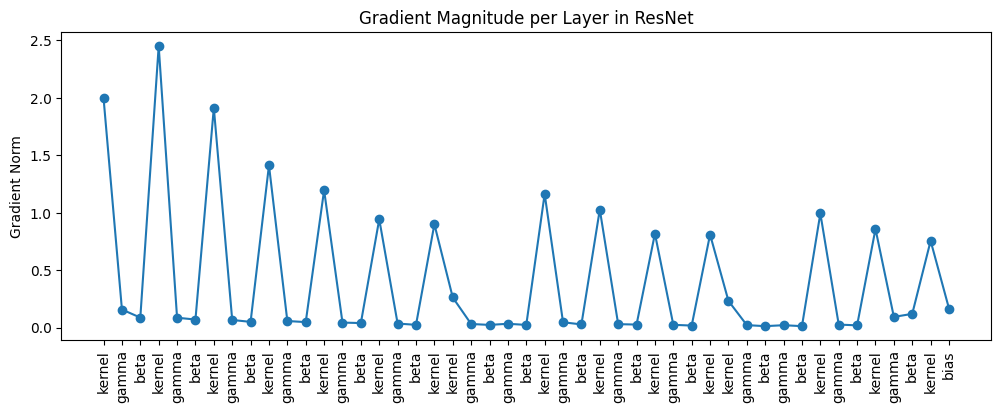

In [35]:
grad_norms_resnet = []
layer_names_resnet = []

for var, grad in zip(model_resnet.trainable_weights, grads_rn):
    if grad is not None:
        grad_norms_resnet.append(tf.norm(grad).numpy())
        layer_names_resnet.append(var.name)

plt.figure(figsize=(12,4))
plt.plot(grad_norms_resnet, marker='o')
plt.xticks(range(len(layer_names_resnet)), layer_names_resnet, rotation=90)
plt.ylabel("Gradient Norm")
plt.title("Gradient Magnitude per Layer in ResNet")
plt.show()